In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

In [2]:
# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd cs231n/datasets/
!bash get_datasets.sh
%cd -

/home/pchen/Desktop/cs241n/assn/assignment2/cs231n/datasets
/home/pchen/Desktop/cs241n/assn/assignment2


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [3]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.


In [4]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [5]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.212047930816777e-05
W3 relative error: 4.5623278145362223e-07
b1 relative error: 4.660094372886962e-09
b2 relative error: 2.085654124402131e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.409028728052923e-08
W2 relative error: 6.86942277940646e-08
W3 relative error: 2.1311298702113723e-08
b1 relative error: 1.475242751587128e-08
b2 relative error: 1.7223751746766738e-09
b3 relative error: 2.378772438198909e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.098000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.114000
(Epoch 2 / 20) train acc: 0.380000; val_acc: 0.137000
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.156000
(Epoch 4 / 20) train acc: 0.420000; val_acc: 0.160000
(Epoch 5 / 20) train acc: 0.440000; val_acc: 0.155000
(Iteration 11 / 40) loss: 1.418851
(Epoch 6 / 20) train acc: 0.540000; val_acc: 0.182000
(Epoch 7 / 20) train acc: 0.560000; val_acc: 0.170000
(Epoch 8 / 20) train acc: 0.680000; val_acc: 0.174000
(Epoch 9 / 20) train acc: 0.760000; val_acc: 0.198000
(Epoch 10 / 20) train acc: 0.780000; val_acc: 0.196000
(Iteration 21 / 40) loss: 0.924221
(Epoch 11 / 20) train acc: 0.900000; val_acc: 0.203000
(Epoch 12 / 20) train acc: 0.900000; val_acc: 0.202000
(Epoch 13 / 20) train acc: 0.860000; val_acc: 0.191000
(Epoch 14 / 20) train acc: 0.860000; val_acc: 0.190000
(Epoch 15 / 20) train acc: 0.960000; val_acc: 0.207000
(Iteration 31 / 40) loss: 

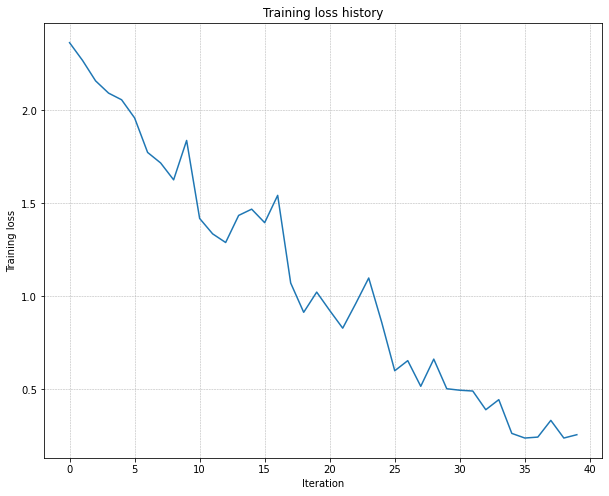

In [6]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 5e-3  # Experiment with this!
model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 28.032018
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.121000
(Epoch 1 / 20) train acc: 0.300000; val_acc: 0.120000
(Epoch 2 / 20) train acc: 0.380000; val_acc: 0.105000
(Epoch 3 / 20) train acc: 0.460000; val_acc: 0.121000
(Epoch 4 / 20) train acc: 0.580000; val_acc: 0.120000
(Epoch 5 / 20) train acc: 0.580000; val_acc: 0.104000
(Iteration 11 / 40) loss: 2.526579
(Epoch 6 / 20) train acc: 0.760000; val_acc: 0.129000
(Epoch 7 / 20) train acc: 0.720000; val_acc: 0.121000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.120000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.115000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.122000
(Iteration 21 / 40) loss: 0.242206
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.121000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.126000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.121000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.121000
(Epoch 15 / 20) train acc: 0.960000; val_acc: 0.121000
(Iteration 31 / 40) loss:

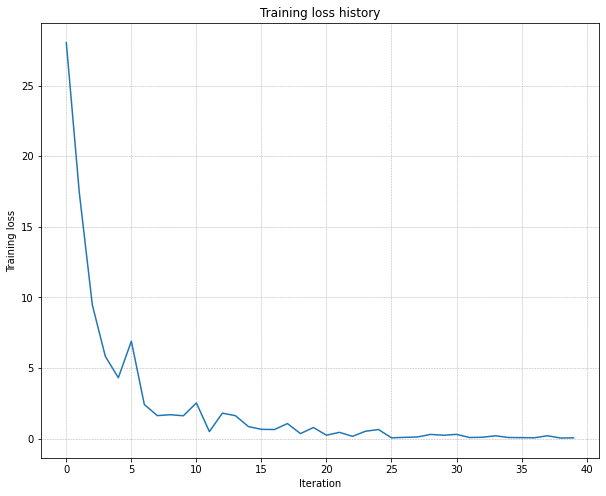

In [7]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 5e-4  # Experiment with this!
weight_scale = 7e-2   # Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1: 
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
Training deeper network is harder to train since the early layers are more likely to suffer from diminishing gradients.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [10]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.104000; val_acc: 0.107000
(Iteration 11 / 200) loss: 2.356069
(Iteration 21 / 200) loss: 2.214091
(Iteration 31 / 200) loss: 2.205928
(Epoch 1 / 5) train acc: 0.225000; val_acc: 0.193000
(Iteration 41 / 200) loss: 2.132095
(Iteration 51 / 200) loss: 2.118950
(Iteration 61 / 200) loss: 2.116443
(Iteration 71 / 200) loss: 2.132549
(Epoch 2 / 5) train acc: 0.298000; val_acc: 0.260000
(Iteration 81 / 200) loss: 1.977227
(Iteration 91 / 200) loss: 2.007528
(Iteration 101 / 200) loss: 2.004762
(Iteration 111 / 200) loss: 1.885342
(Epoch 3 / 5) train acc: 0.343000; val_acc: 0.287000
(Iteration 121 / 200) loss: 1.891516
(Iteration 131 / 200) loss: 1.923677
(Iteration 141 / 200) loss: 1.957743
(Iteration 151 / 200) loss: 1.966736
(Epoch 4 / 5) train acc: 0.322000; val_acc: 0.305000
(Iteration 161 / 200) loss: 1.801483
(Iteration 171 / 200) loss: 1.973779
(Iteration 181 / 200) loss: 1.666572
(Iteration 191 / 200) los

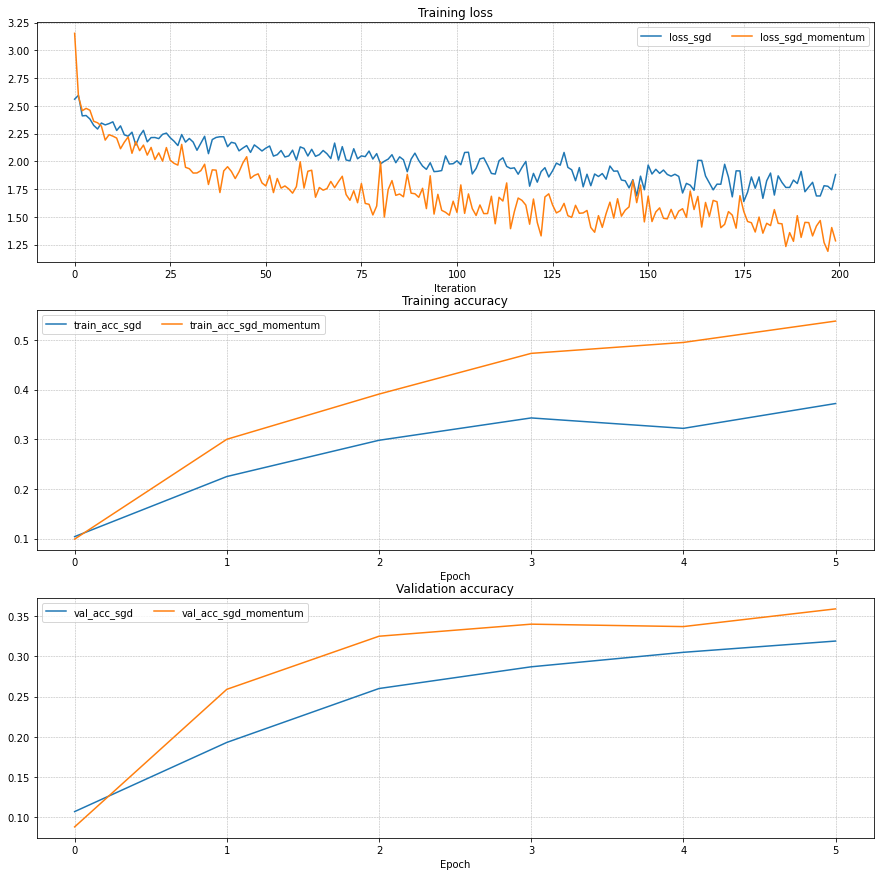

In [11]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [15]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [18]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.027712
(Iteration 21 / 200) loss: 2.183358
(Iteration 31 / 200) loss: 1.744257
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.330000
(Iteration 41 / 200) loss: 1.707951
(Iteration 51 / 200) loss: 1.703835
(Iteration 61 / 200) loss: 2.094758
(Iteration 71 / 200) loss: 1.505557
(Epoch 2 / 5) train acc: 0.419000; val_acc: 0.362000
(Iteration 81 / 200) loss: 1.594429
(Iteration 91 / 200) loss: 1.519016
(Iteration 101 / 200) loss: 1.368522
(Iteration 111 / 200) loss: 1.470400
(Epoch 3 / 5) train acc: 0.460000; val_acc: 0.378000
(Iteration 121 / 200) loss: 1.199064
(Iteration 131 / 200) loss: 1.464704
(Iteration 141 / 200) loss: 1.359863
(Iteration 151 / 200) loss: 1.415068
(Epoch 4 / 5) train acc: 0.521000; val_acc: 0.374000
(Iteration 161 / 200) loss: 1.382818
(Iteration 171 / 200) loss: 1.359900
(Iteration 181 / 200) loss: 1.095948
(Iteration 191 / 200) lo

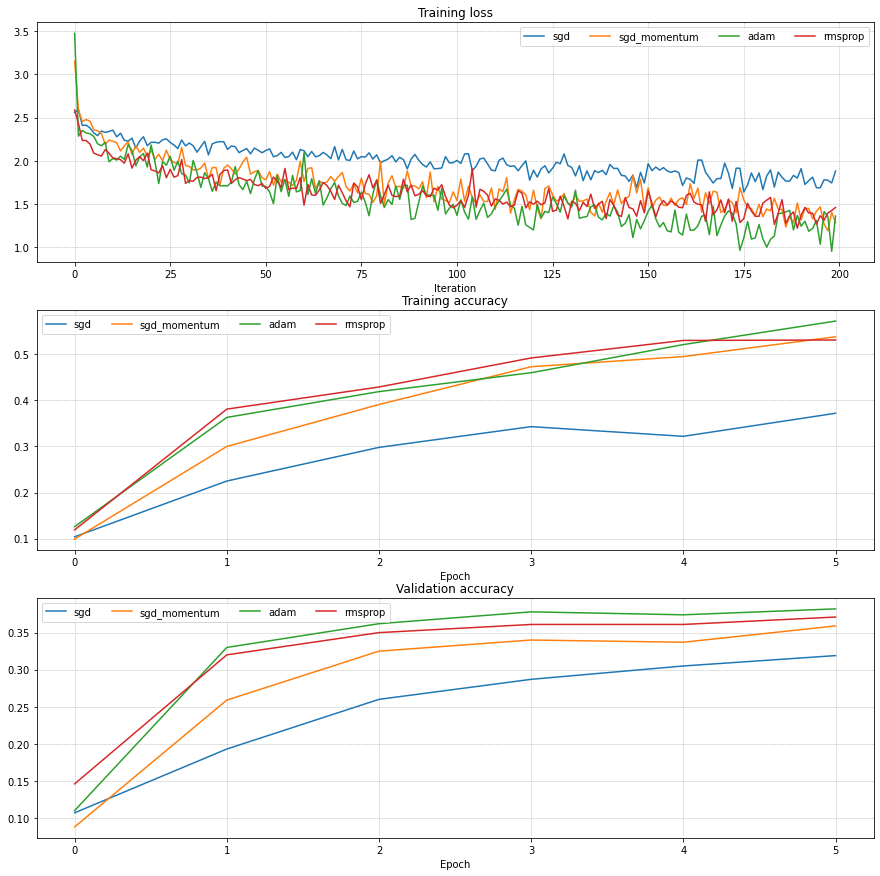

In [19]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer: 
The variable cache gets increasingly larger which has a learning rate decay effect. Adam eliminates this issue by keeping a moving average of this cache that is not necessarily increasing, same as RMSprop.


# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [36]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

lrs = [5e-4]
regs = [1e1, 1e2, 5e2, 1e3]

#learning_rate = 5e-4  # Experiment with this!
#weight_scale = 7e-2   # Experiment with this!

best_acc = -1
best_params = None
        
for lr in lrs:
    for reg in regs:        
        model = FullyConnectedNet([100, 100, 100, 100], 
                                 weight_scale=7e-2)

        solver = Solver(
            model,
            data,
            num_epochs=50,
            batch_size=100,
            update_rule='adam',
            optim_config={'learning_rate': lr},
            verbose=True
        )
        solver.train()
        res = 'lr: {}, reg: {}, val_acc: {}'.format(lr, reg, solver.best_val_acc)
        print(res)
        if solver.best_val_acc > best_acc:
            best_acc = solver.best_val_acc
            best_params = solver.best_params
            best_hyperp = {'lr': lr, 'reg': reg}
            best_model = model


    
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 24500) loss: 23.790750
(Epoch 0 / 50) train acc: 0.117000; val_acc: 0.102000
(Iteration 11 / 24500) loss: 7.407867
(Iteration 21 / 24500) loss: 5.148901
(Iteration 31 / 24500) loss: 4.498303
(Iteration 41 / 24500) loss: 4.000230
(Iteration 51 / 24500) loss: 2.968841
(Iteration 61 / 24500) loss: 2.604684
(Iteration 71 / 24500) loss: 2.513422
(Iteration 81 / 24500) loss: 2.360855
(Iteration 91 / 24500) loss: 2.848610
(Iteration 101 / 24500) loss: 2.291341
(Iteration 111 / 24500) loss: 2.006592
(Iteration 121 / 24500) loss: 2.465511
(Iteration 131 / 24500) loss: 2.396589
(Iteration 141 / 24500) loss: 2.179248
(Iteration 151 / 24500) loss: 1.897151
(Iteration 161 / 24500) loss: 2.170033
(Iteration 171 / 24500) loss: 2.053810
(Iteration 181 / 24500) loss: 2.199834
(Iteration 191 / 24500) loss: 1.801820
(Iteration 201 / 24500) loss: 2.015923
(Iteration 211 / 24500) loss: 2.038259
(Iteration 221 / 24500) loss: 2.072034
(Iteration 231 / 24500) loss: 2.181302
(Iteration 241 / 245

(Iteration 2031 / 24500) loss: 1.526096
(Iteration 2041 / 24500) loss: 1.423616
(Iteration 2051 / 24500) loss: 1.596462
(Iteration 2061 / 24500) loss: 1.454736
(Iteration 2071 / 24500) loss: 1.315663
(Iteration 2081 / 24500) loss: 1.437234
(Iteration 2091 / 24500) loss: 1.349149
(Iteration 2101 / 24500) loss: 1.618757
(Iteration 2111 / 24500) loss: 1.432671
(Iteration 2121 / 24500) loss: 1.408448
(Iteration 2131 / 24500) loss: 1.406523
(Iteration 2141 / 24500) loss: 1.291826
(Iteration 2151 / 24500) loss: 1.371790
(Iteration 2161 / 24500) loss: 1.504237
(Iteration 2171 / 24500) loss: 1.475096
(Iteration 2181 / 24500) loss: 1.330689
(Iteration 2191 / 24500) loss: 1.637504
(Iteration 2201 / 24500) loss: 1.495358
(Iteration 2211 / 24500) loss: 1.409686
(Iteration 2221 / 24500) loss: 1.406303
(Iteration 2231 / 24500) loss: 1.412922
(Iteration 2241 / 24500) loss: 1.239899
(Iteration 2251 / 24500) loss: 1.331074
(Iteration 2261 / 24500) loss: 1.298055
(Iteration 2271 / 24500) loss: 1.385294


(Iteration 4041 / 24500) loss: 1.109322
(Iteration 4051 / 24500) loss: 1.185576
(Iteration 4061 / 24500) loss: 1.495586
(Iteration 4071 / 24500) loss: 1.201041
(Iteration 4081 / 24500) loss: 1.194294
(Iteration 4091 / 24500) loss: 1.291452
(Iteration 4101 / 24500) loss: 1.069575
(Iteration 4111 / 24500) loss: 1.267863
(Iteration 4121 / 24500) loss: 1.174583
(Iteration 4131 / 24500) loss: 1.246020
(Iteration 4141 / 24500) loss: 1.095586
(Iteration 4151 / 24500) loss: 1.109063
(Iteration 4161 / 24500) loss: 1.170608
(Iteration 4171 / 24500) loss: 1.154151
(Iteration 4181 / 24500) loss: 1.300996
(Iteration 4191 / 24500) loss: 1.258199
(Iteration 4201 / 24500) loss: 1.045292
(Iteration 4211 / 24500) loss: 1.479318
(Iteration 4221 / 24500) loss: 1.261628
(Iteration 4231 / 24500) loss: 1.165706
(Iteration 4241 / 24500) loss: 1.117888
(Iteration 4251 / 24500) loss: 1.286143
(Iteration 4261 / 24500) loss: 1.204960
(Iteration 4271 / 24500) loss: 1.171063
(Iteration 4281 / 24500) loss: 1.336224


(Iteration 6041 / 24500) loss: 1.185996
(Iteration 6051 / 24500) loss: 1.092970
(Iteration 6061 / 24500) loss: 1.152711
(Iteration 6071 / 24500) loss: 1.025296
(Iteration 6081 / 24500) loss: 1.318917
(Iteration 6091 / 24500) loss: 1.130747
(Iteration 6101 / 24500) loss: 0.960251
(Iteration 6111 / 24500) loss: 1.040752
(Iteration 6121 / 24500) loss: 0.949074
(Iteration 6131 / 24500) loss: 0.991933
(Iteration 6141 / 24500) loss: 1.148421
(Iteration 6151 / 24500) loss: 1.094279
(Iteration 6161 / 24500) loss: 1.224046
(Iteration 6171 / 24500) loss: 0.958090
(Iteration 6181 / 24500) loss: 0.904532
(Iteration 6191 / 24500) loss: 1.118708
(Iteration 6201 / 24500) loss: 0.926943
(Iteration 6211 / 24500) loss: 1.217137
(Iteration 6221 / 24500) loss: 1.018387
(Iteration 6231 / 24500) loss: 0.915956
(Iteration 6241 / 24500) loss: 1.031755
(Iteration 6251 / 24500) loss: 1.070050
(Iteration 6261 / 24500) loss: 1.027046
(Iteration 6271 / 24500) loss: 1.161798
(Iteration 6281 / 24500) loss: 0.965455


(Iteration 8041 / 24500) loss: 0.988170
(Iteration 8051 / 24500) loss: 1.018436
(Iteration 8061 / 24500) loss: 1.025344
(Iteration 8071 / 24500) loss: 1.165809
(Iteration 8081 / 24500) loss: 0.957015
(Iteration 8091 / 24500) loss: 0.854201
(Iteration 8101 / 24500) loss: 1.038535
(Iteration 8111 / 24500) loss: 1.117279
(Iteration 8121 / 24500) loss: 0.885849
(Iteration 8131 / 24500) loss: 0.863092
(Iteration 8141 / 24500) loss: 0.848771
(Iteration 8151 / 24500) loss: 0.925581
(Iteration 8161 / 24500) loss: 0.975651
(Iteration 8171 / 24500) loss: 1.044712
(Iteration 8181 / 24500) loss: 0.769702
(Iteration 8191 / 24500) loss: 0.994695
(Iteration 8201 / 24500) loss: 0.821534
(Iteration 8211 / 24500) loss: 0.946367
(Iteration 8221 / 24500) loss: 0.873730
(Iteration 8231 / 24500) loss: 1.067073
(Iteration 8241 / 24500) loss: 1.071659
(Iteration 8251 / 24500) loss: 0.926446
(Iteration 8261 / 24500) loss: 0.957105
(Iteration 8271 / 24500) loss: 1.042650
(Iteration 8281 / 24500) loss: 0.948041


(Iteration 10041 / 24500) loss: 1.011711
(Iteration 10051 / 24500) loss: 0.970601
(Iteration 10061 / 24500) loss: 1.103365
(Iteration 10071 / 24500) loss: 0.745515
(Iteration 10081 / 24500) loss: 0.678172
(Iteration 10091 / 24500) loss: 0.713265
(Iteration 10101 / 24500) loss: 0.807710
(Iteration 10111 / 24500) loss: 0.909467
(Iteration 10121 / 24500) loss: 0.944092
(Iteration 10131 / 24500) loss: 1.021323
(Iteration 10141 / 24500) loss: 0.988730
(Iteration 10151 / 24500) loss: 0.783002
(Iteration 10161 / 24500) loss: 0.782363
(Iteration 10171 / 24500) loss: 0.816163
(Iteration 10181 / 24500) loss: 1.184316
(Iteration 10191 / 24500) loss: 0.943883
(Iteration 10201 / 24500) loss: 1.038707
(Iteration 10211 / 24500) loss: 1.005140
(Iteration 10221 / 24500) loss: 1.099180
(Iteration 10231 / 24500) loss: 1.085306
(Iteration 10241 / 24500) loss: 0.811776
(Iteration 10251 / 24500) loss: 0.810425
(Iteration 10261 / 24500) loss: 0.919399
(Iteration 10271 / 24500) loss: 0.952974
(Iteration 10281

(Iteration 11991 / 24500) loss: 0.822787
(Iteration 12001 / 24500) loss: 0.866389
(Iteration 12011 / 24500) loss: 0.839971
(Iteration 12021 / 24500) loss: 0.672465
(Iteration 12031 / 24500) loss: 0.769128
(Iteration 12041 / 24500) loss: 0.898176
(Iteration 12051 / 24500) loss: 0.752302
(Iteration 12061 / 24500) loss: 0.688927
(Iteration 12071 / 24500) loss: 0.770712
(Iteration 12081 / 24500) loss: 0.730098
(Iteration 12091 / 24500) loss: 0.651802
(Iteration 12101 / 24500) loss: 0.903022
(Iteration 12111 / 24500) loss: 0.724241
(Iteration 12121 / 24500) loss: 0.818185
(Iteration 12131 / 24500) loss: 0.778561
(Iteration 12141 / 24500) loss: 0.725962
(Iteration 12151 / 24500) loss: 0.898051
(Iteration 12161 / 24500) loss: 0.777881
(Iteration 12171 / 24500) loss: 0.970663
(Iteration 12181 / 24500) loss: 1.008593
(Iteration 12191 / 24500) loss: 0.639754
(Iteration 12201 / 24500) loss: 0.749434
(Iteration 12211 / 24500) loss: 0.721239
(Iteration 12221 / 24500) loss: 0.743738
(Iteration 12231

(Iteration 13951 / 24500) loss: 0.676824
(Iteration 13961 / 24500) loss: 0.774796
(Iteration 13971 / 24500) loss: 0.684302
(Iteration 13981 / 24500) loss: 0.665226
(Iteration 13991 / 24500) loss: 0.728524
(Iteration 14001 / 24500) loss: 0.718616
(Iteration 14011 / 24500) loss: 0.515660
(Iteration 14021 / 24500) loss: 0.807298
(Iteration 14031 / 24500) loss: 0.544306
(Iteration 14041 / 24500) loss: 0.746803
(Iteration 14051 / 24500) loss: 0.636289
(Iteration 14061 / 24500) loss: 0.791217
(Iteration 14071 / 24500) loss: 0.787602
(Iteration 14081 / 24500) loss: 1.133947
(Iteration 14091 / 24500) loss: 0.703447
(Iteration 14101 / 24500) loss: 0.566041
(Iteration 14111 / 24500) loss: 0.704856
(Iteration 14121 / 24500) loss: 0.886222
(Iteration 14131 / 24500) loss: 0.649969
(Iteration 14141 / 24500) loss: 0.675139
(Iteration 14151 / 24500) loss: 0.761213
(Iteration 14161 / 24500) loss: 0.905764
(Iteration 14171 / 24500) loss: 0.824926
(Iteration 14181 / 24500) loss: 0.825998
(Iteration 14191

(Iteration 15911 / 24500) loss: 0.657458
(Iteration 15921 / 24500) loss: 0.693421
(Iteration 15931 / 24500) loss: 0.745382
(Iteration 15941 / 24500) loss: 0.612640
(Iteration 15951 / 24500) loss: 0.558177
(Iteration 15961 / 24500) loss: 0.591766
(Iteration 15971 / 24500) loss: 0.677438
(Iteration 15981 / 24500) loss: 0.725730
(Iteration 15991 / 24500) loss: 0.565790
(Iteration 16001 / 24500) loss: 0.561278
(Iteration 16011 / 24500) loss: 0.580120
(Iteration 16021 / 24500) loss: 0.743583
(Iteration 16031 / 24500) loss: 0.553396
(Iteration 16041 / 24500) loss: 0.615248
(Iteration 16051 / 24500) loss: 0.795798
(Iteration 16061 / 24500) loss: 0.738545
(Iteration 16071 / 24500) loss: 0.736107
(Iteration 16081 / 24500) loss: 0.676734
(Iteration 16091 / 24500) loss: 0.689655
(Iteration 16101 / 24500) loss: 0.697411
(Iteration 16111 / 24500) loss: 0.699444
(Iteration 16121 / 24500) loss: 0.780709
(Iteration 16131 / 24500) loss: 0.518873
(Iteration 16141 / 24500) loss: 0.621316
(Iteration 16151

(Iteration 17871 / 24500) loss: 0.592469
(Iteration 17881 / 24500) loss: 0.704493
(Iteration 17891 / 24500) loss: 0.601808
(Iteration 17901 / 24500) loss: 0.610797
(Iteration 17911 / 24500) loss: 0.637202
(Iteration 17921 / 24500) loss: 0.728517
(Iteration 17931 / 24500) loss: 0.607732
(Iteration 17941 / 24500) loss: 0.535161
(Iteration 17951 / 24500) loss: 0.587568
(Iteration 17961 / 24500) loss: 0.748433
(Iteration 17971 / 24500) loss: 0.533399
(Iteration 17981 / 24500) loss: 0.488036
(Iteration 17991 / 24500) loss: 0.762078
(Iteration 18001 / 24500) loss: 0.445355
(Iteration 18011 / 24500) loss: 0.593806
(Iteration 18021 / 24500) loss: 0.502488
(Iteration 18031 / 24500) loss: 0.586825
(Iteration 18041 / 24500) loss: 0.594354
(Iteration 18051 / 24500) loss: 0.892983
(Iteration 18061 / 24500) loss: 0.501897
(Iteration 18071 / 24500) loss: 0.756025
(Iteration 18081 / 24500) loss: 0.727340
(Iteration 18091 / 24500) loss: 0.528904
(Iteration 18101 / 24500) loss: 0.588111
(Iteration 18111

(Iteration 19821 / 24500) loss: 0.627312
(Iteration 19831 / 24500) loss: 0.631211
(Iteration 19841 / 24500) loss: 0.524289
(Iteration 19851 / 24500) loss: 0.474684
(Iteration 19861 / 24500) loss: 0.625582
(Iteration 19871 / 24500) loss: 0.539308
(Iteration 19881 / 24500) loss: 0.671393
(Iteration 19891 / 24500) loss: 0.760667
(Iteration 19901 / 24500) loss: 0.404423
(Iteration 19911 / 24500) loss: 0.451067
(Iteration 19921 / 24500) loss: 0.736115
(Iteration 19931 / 24500) loss: 0.534549
(Iteration 19941 / 24500) loss: 0.568166
(Iteration 19951 / 24500) loss: 0.601579
(Iteration 19961 / 24500) loss: 0.544150
(Iteration 19971 / 24500) loss: 0.589439
(Iteration 19981 / 24500) loss: 0.628405
(Iteration 19991 / 24500) loss: 0.411292
(Iteration 20001 / 24500) loss: 0.493232
(Iteration 20011 / 24500) loss: 0.646913
(Iteration 20021 / 24500) loss: 0.687637
(Iteration 20031 / 24500) loss: 0.724732
(Iteration 20041 / 24500) loss: 0.530465
(Iteration 20051 / 24500) loss: 0.577915
(Iteration 20061

(Iteration 21771 / 24500) loss: 0.495797
(Iteration 21781 / 24500) loss: 0.710093
(Iteration 21791 / 24500) loss: 0.505127
(Iteration 21801 / 24500) loss: 0.540894
(Iteration 21811 / 24500) loss: 0.509355
(Iteration 21821 / 24500) loss: 0.610627
(Iteration 21831 / 24500) loss: 0.534468
(Iteration 21841 / 24500) loss: 0.421499
(Iteration 21851 / 24500) loss: 0.649515
(Iteration 21861 / 24500) loss: 0.743705
(Iteration 21871 / 24500) loss: 0.579687
(Iteration 21881 / 24500) loss: 0.746737
(Iteration 21891 / 24500) loss: 0.762558
(Iteration 21901 / 24500) loss: 0.509973
(Iteration 21911 / 24500) loss: 0.595978
(Iteration 21921 / 24500) loss: 0.443365
(Iteration 21931 / 24500) loss: 0.474190
(Iteration 21941 / 24500) loss: 0.445147
(Iteration 21951 / 24500) loss: 0.555158
(Iteration 21961 / 24500) loss: 0.671090
(Iteration 21971 / 24500) loss: 0.591884
(Iteration 21981 / 24500) loss: 0.394249
(Iteration 21991 / 24500) loss: 0.615058
(Iteration 22001 / 24500) loss: 0.509890
(Iteration 22011

(Iteration 23731 / 24500) loss: 0.468732
(Iteration 23741 / 24500) loss: 0.533575
(Iteration 23751 / 24500) loss: 0.488569
(Iteration 23761 / 24500) loss: 0.666230
(Iteration 23771 / 24500) loss: 0.437291
(Iteration 23781 / 24500) loss: 0.440426
(Iteration 23791 / 24500) loss: 0.595541
(Iteration 23801 / 24500) loss: 0.438456
(Iteration 23811 / 24500) loss: 0.622611
(Iteration 23821 / 24500) loss: 0.517402
(Iteration 23831 / 24500) loss: 0.559997
(Iteration 23841 / 24500) loss: 0.435276
(Iteration 23851 / 24500) loss: 0.471193
(Iteration 23861 / 24500) loss: 0.551780
(Iteration 23871 / 24500) loss: 0.451792
(Iteration 23881 / 24500) loss: 0.656360
(Iteration 23891 / 24500) loss: 0.686813
(Iteration 23901 / 24500) loss: 0.534128
(Iteration 23911 / 24500) loss: 0.352169
(Iteration 23921 / 24500) loss: 0.533071
(Iteration 23931 / 24500) loss: 0.480417
(Iteration 23941 / 24500) loss: 0.473494
(Iteration 23951 / 24500) loss: 0.573606
(Iteration 23961 / 24500) loss: 0.549815
(Iteration 23971

(Iteration 1211 / 24500) loss: 1.327598
(Iteration 1221 / 24500) loss: 1.579413
(Iteration 1231 / 24500) loss: 1.561786
(Iteration 1241 / 24500) loss: 1.604166
(Iteration 1251 / 24500) loss: 1.533324
(Iteration 1261 / 24500) loss: 1.630070
(Iteration 1271 / 24500) loss: 1.592514
(Iteration 1281 / 24500) loss: 1.724222
(Iteration 1291 / 24500) loss: 1.606539
(Iteration 1301 / 24500) loss: 1.654579
(Iteration 1311 / 24500) loss: 1.530368
(Iteration 1321 / 24500) loss: 1.783735
(Iteration 1331 / 24500) loss: 1.571138
(Iteration 1341 / 24500) loss: 1.518247
(Iteration 1351 / 24500) loss: 1.735192
(Iteration 1361 / 24500) loss: 1.495492
(Iteration 1371 / 24500) loss: 1.616684
(Iteration 1381 / 24500) loss: 1.806712
(Iteration 1391 / 24500) loss: 1.530170
(Iteration 1401 / 24500) loss: 1.420672
(Iteration 1411 / 24500) loss: 1.719076
(Iteration 1421 / 24500) loss: 1.436341
(Iteration 1431 / 24500) loss: 1.589019
(Iteration 1441 / 24500) loss: 1.390784
(Iteration 1451 / 24500) loss: 1.452852


(Iteration 3211 / 24500) loss: 1.181868
(Iteration 3221 / 24500) loss: 1.294099
(Iteration 3231 / 24500) loss: 1.275447
(Iteration 3241 / 24500) loss: 1.452983
(Iteration 3251 / 24500) loss: 1.172381
(Iteration 3261 / 24500) loss: 1.202201
(Iteration 3271 / 24500) loss: 1.295150
(Iteration 3281 / 24500) loss: 1.166966
(Iteration 3291 / 24500) loss: 1.315870
(Iteration 3301 / 24500) loss: 1.414108
(Iteration 3311 / 24500) loss: 1.221628
(Iteration 3321 / 24500) loss: 1.353031
(Iteration 3331 / 24500) loss: 1.297637
(Iteration 3341 / 24500) loss: 1.392109
(Iteration 3351 / 24500) loss: 1.034077
(Iteration 3361 / 24500) loss: 1.245225
(Iteration 3371 / 24500) loss: 1.193464
(Iteration 3381 / 24500) loss: 1.326999
(Iteration 3391 / 24500) loss: 1.384625
(Iteration 3401 / 24500) loss: 1.355129
(Iteration 3411 / 24500) loss: 1.199058
(Iteration 3421 / 24500) loss: 1.419821
(Epoch 7 / 50) train acc: 0.570000; val_acc: 0.473000
(Iteration 3431 / 24500) loss: 1.282511
(Iteration 3441 / 24500) l

(Iteration 5211 / 24500) loss: 1.165216
(Iteration 5221 / 24500) loss: 1.192987
(Iteration 5231 / 24500) loss: 1.014044
(Iteration 5241 / 24500) loss: 1.384814
(Iteration 5251 / 24500) loss: 1.075585
(Iteration 5261 / 24500) loss: 1.184809
(Iteration 5271 / 24500) loss: 1.133670
(Iteration 5281 / 24500) loss: 1.180892
(Iteration 5291 / 24500) loss: 1.377465
(Iteration 5301 / 24500) loss: 1.297725
(Iteration 5311 / 24500) loss: 1.114184
(Iteration 5321 / 24500) loss: 1.154722
(Iteration 5331 / 24500) loss: 1.051612
(Iteration 5341 / 24500) loss: 0.908740
(Iteration 5351 / 24500) loss: 1.063259
(Iteration 5361 / 24500) loss: 1.066747
(Iteration 5371 / 24500) loss: 1.132158
(Iteration 5381 / 24500) loss: 0.980251
(Epoch 11 / 50) train acc: 0.616000; val_acc: 0.492000
(Iteration 5391 / 24500) loss: 1.059578
(Iteration 5401 / 24500) loss: 1.118593
(Iteration 5411 / 24500) loss: 1.111826
(Iteration 5421 / 24500) loss: 1.278498
(Iteration 5431 / 24500) loss: 1.439012
(Iteration 5441 / 24500) 

(Iteration 7211 / 24500) loss: 1.108549
(Iteration 7221 / 24500) loss: 0.881805
(Iteration 7231 / 24500) loss: 1.176840
(Iteration 7241 / 24500) loss: 1.066274
(Iteration 7251 / 24500) loss: 0.871230
(Iteration 7261 / 24500) loss: 1.042933
(Iteration 7271 / 24500) loss: 1.069888
(Iteration 7281 / 24500) loss: 1.069097
(Iteration 7291 / 24500) loss: 1.171441
(Iteration 7301 / 24500) loss: 0.855216
(Iteration 7311 / 24500) loss: 0.832499
(Iteration 7321 / 24500) loss: 0.907769
(Iteration 7331 / 24500) loss: 1.155469
(Iteration 7341 / 24500) loss: 0.835229
(Epoch 15 / 50) train acc: 0.655000; val_acc: 0.504000
(Iteration 7351 / 24500) loss: 1.016089
(Iteration 7361 / 24500) loss: 1.176596
(Iteration 7371 / 24500) loss: 1.060686
(Iteration 7381 / 24500) loss: 1.209736
(Iteration 7391 / 24500) loss: 1.076580
(Iteration 7401 / 24500) loss: 1.022723
(Iteration 7411 / 24500) loss: 1.061645
(Iteration 7421 / 24500) loss: 1.005311
(Iteration 7431 / 24500) loss: 0.988512
(Iteration 7441 / 24500) 

(Iteration 9211 / 24500) loss: 0.897863
(Iteration 9221 / 24500) loss: 1.013589
(Iteration 9231 / 24500) loss: 0.812021
(Iteration 9241 / 24500) loss: 0.919566
(Iteration 9251 / 24500) loss: 0.869324
(Iteration 9261 / 24500) loss: 1.081002
(Iteration 9271 / 24500) loss: 1.052928
(Iteration 9281 / 24500) loss: 1.015995
(Iteration 9291 / 24500) loss: 1.041535
(Iteration 9301 / 24500) loss: 0.955902
(Epoch 19 / 50) train acc: 0.632000; val_acc: 0.482000
(Iteration 9311 / 24500) loss: 0.644287
(Iteration 9321 / 24500) loss: 0.962673
(Iteration 9331 / 24500) loss: 1.036953
(Iteration 9341 / 24500) loss: 0.927466
(Iteration 9351 / 24500) loss: 0.779005
(Iteration 9361 / 24500) loss: 0.881598
(Iteration 9371 / 24500) loss: 1.021370
(Iteration 9381 / 24500) loss: 0.868172
(Iteration 9391 / 24500) loss: 1.065358
(Iteration 9401 / 24500) loss: 0.723344
(Iteration 9411 / 24500) loss: 0.868052
(Iteration 9421 / 24500) loss: 0.848981
(Iteration 9431 / 24500) loss: 0.870203
(Iteration 9441 / 24500) 

(Iteration 11181 / 24500) loss: 0.905798
(Iteration 11191 / 24500) loss: 0.939140
(Iteration 11201 / 24500) loss: 0.927095
(Iteration 11211 / 24500) loss: 0.872122
(Iteration 11221 / 24500) loss: 1.014424
(Iteration 11231 / 24500) loss: 0.949604
(Iteration 11241 / 24500) loss: 0.857024
(Iteration 11251 / 24500) loss: 0.728415
(Iteration 11261 / 24500) loss: 0.717220
(Epoch 23 / 50) train acc: 0.697000; val_acc: 0.482000
(Iteration 11271 / 24500) loss: 0.836417
(Iteration 11281 / 24500) loss: 0.944882
(Iteration 11291 / 24500) loss: 0.855123
(Iteration 11301 / 24500) loss: 0.915579
(Iteration 11311 / 24500) loss: 0.849423
(Iteration 11321 / 24500) loss: 0.636783
(Iteration 11331 / 24500) loss: 0.780727
(Iteration 11341 / 24500) loss: 0.543527
(Iteration 11351 / 24500) loss: 0.929555
(Iteration 11361 / 24500) loss: 0.775983
(Iteration 11371 / 24500) loss: 0.735432
(Iteration 11381 / 24500) loss: 0.903551
(Iteration 11391 / 24500) loss: 0.873703
(Iteration 11401 / 24500) loss: 1.152687
(I

(Iteration 13141 / 24500) loss: 0.766674
(Iteration 13151 / 24500) loss: 0.881250
(Iteration 13161 / 24500) loss: 0.751505
(Iteration 13171 / 24500) loss: 0.629569
(Iteration 13181 / 24500) loss: 0.768015
(Iteration 13191 / 24500) loss: 0.708160
(Iteration 13201 / 24500) loss: 0.757528
(Iteration 13211 / 24500) loss: 0.659100
(Iteration 13221 / 24500) loss: 0.752436
(Epoch 27 / 50) train acc: 0.733000; val_acc: 0.478000
(Iteration 13231 / 24500) loss: 0.768027
(Iteration 13241 / 24500) loss: 0.958801
(Iteration 13251 / 24500) loss: 0.761999
(Iteration 13261 / 24500) loss: 0.883729
(Iteration 13271 / 24500) loss: 0.638014
(Iteration 13281 / 24500) loss: 0.864206
(Iteration 13291 / 24500) loss: 0.645051
(Iteration 13301 / 24500) loss: 0.683268
(Iteration 13311 / 24500) loss: 0.803889
(Iteration 13321 / 24500) loss: 0.667592
(Iteration 13331 / 24500) loss: 0.552455
(Iteration 13341 / 24500) loss: 0.847420
(Iteration 13351 / 24500) loss: 0.645288
(Iteration 13361 / 24500) loss: 0.697778
(I

(Iteration 15101 / 24500) loss: 0.622629
(Iteration 15111 / 24500) loss: 0.490429
(Iteration 15121 / 24500) loss: 0.753081
(Iteration 15131 / 24500) loss: 0.525509
(Iteration 15141 / 24500) loss: 0.480872
(Iteration 15151 / 24500) loss: 0.631613
(Iteration 15161 / 24500) loss: 0.711339
(Iteration 15171 / 24500) loss: 0.618187
(Iteration 15181 / 24500) loss: 0.719087
(Epoch 31 / 50) train acc: 0.745000; val_acc: 0.470000
(Iteration 15191 / 24500) loss: 0.630718
(Iteration 15201 / 24500) loss: 0.619780
(Iteration 15211 / 24500) loss: 0.684248
(Iteration 15221 / 24500) loss: 0.561747
(Iteration 15231 / 24500) loss: 0.697386
(Iteration 15241 / 24500) loss: 0.789715
(Iteration 15251 / 24500) loss: 0.681335
(Iteration 15261 / 24500) loss: 0.584186
(Iteration 15271 / 24500) loss: 0.673597
(Iteration 15281 / 24500) loss: 0.585673
(Iteration 15291 / 24500) loss: 0.439134
(Iteration 15301 / 24500) loss: 0.660990
(Iteration 15311 / 24500) loss: 0.629864
(Iteration 15321 / 24500) loss: 0.660148
(I

(Iteration 17061 / 24500) loss: 0.837091
(Iteration 17071 / 24500) loss: 0.844134
(Iteration 17081 / 24500) loss: 0.675412
(Iteration 17091 / 24500) loss: 0.736941
(Iteration 17101 / 24500) loss: 0.547416
(Iteration 17111 / 24500) loss: 0.587097
(Iteration 17121 / 24500) loss: 0.557896
(Iteration 17131 / 24500) loss: 0.536320
(Iteration 17141 / 24500) loss: 0.777436
(Epoch 35 / 50) train acc: 0.753000; val_acc: 0.463000
(Iteration 17151 / 24500) loss: 0.662878
(Iteration 17161 / 24500) loss: 0.774273
(Iteration 17171 / 24500) loss: 0.682027
(Iteration 17181 / 24500) loss: 0.620943
(Iteration 17191 / 24500) loss: 0.616905
(Iteration 17201 / 24500) loss: 0.620105
(Iteration 17211 / 24500) loss: 0.502256
(Iteration 17221 / 24500) loss: 0.547956
(Iteration 17231 / 24500) loss: 0.645490
(Iteration 17241 / 24500) loss: 0.513591
(Iteration 17251 / 24500) loss: 0.677293
(Iteration 17261 / 24500) loss: 0.545811
(Iteration 17271 / 24500) loss: 0.576531
(Iteration 17281 / 24500) loss: 0.609892
(I

(Iteration 19021 / 24500) loss: 0.586652
(Iteration 19031 / 24500) loss: 0.505811
(Iteration 19041 / 24500) loss: 0.507437
(Iteration 19051 / 24500) loss: 0.512165
(Iteration 19061 / 24500) loss: 0.398672
(Iteration 19071 / 24500) loss: 0.536648
(Iteration 19081 / 24500) loss: 0.616197
(Iteration 19091 / 24500) loss: 0.582823
(Iteration 19101 / 24500) loss: 0.605271
(Epoch 39 / 50) train acc: 0.795000; val_acc: 0.491000
(Iteration 19111 / 24500) loss: 0.587994
(Iteration 19121 / 24500) loss: 0.631899
(Iteration 19131 / 24500) loss: 0.575848
(Iteration 19141 / 24500) loss: 0.548810
(Iteration 19151 / 24500) loss: 0.500900
(Iteration 19161 / 24500) loss: 0.503024
(Iteration 19171 / 24500) loss: 0.571678
(Iteration 19181 / 24500) loss: 0.521258
(Iteration 19191 / 24500) loss: 0.796247
(Iteration 19201 / 24500) loss: 0.525249
(Iteration 19211 / 24500) loss: 0.510663
(Iteration 19221 / 24500) loss: 0.530724
(Iteration 19231 / 24500) loss: 0.640999
(Iteration 19241 / 24500) loss: 0.694696
(I

(Iteration 20981 / 24500) loss: 0.446048
(Iteration 20991 / 24500) loss: 0.419999
(Iteration 21001 / 24500) loss: 0.515208
(Iteration 21011 / 24500) loss: 0.505950
(Iteration 21021 / 24500) loss: 0.422182
(Iteration 21031 / 24500) loss: 0.416013
(Iteration 21041 / 24500) loss: 0.612810
(Iteration 21051 / 24500) loss: 0.391626
(Iteration 21061 / 24500) loss: 0.631968
(Epoch 43 / 50) train acc: 0.799000; val_acc: 0.466000
(Iteration 21071 / 24500) loss: 0.681380
(Iteration 21081 / 24500) loss: 0.514941
(Iteration 21091 / 24500) loss: 0.571332
(Iteration 21101 / 24500) loss: 0.560679
(Iteration 21111 / 24500) loss: 0.564165
(Iteration 21121 / 24500) loss: 0.715849
(Iteration 21131 / 24500) loss: 0.426533
(Iteration 21141 / 24500) loss: 0.592942
(Iteration 21151 / 24500) loss: 0.659931
(Iteration 21161 / 24500) loss: 0.616032
(Iteration 21171 / 24500) loss: 0.466049
(Iteration 21181 / 24500) loss: 0.545072
(Iteration 21191 / 24500) loss: 0.552417
(Iteration 21201 / 24500) loss: 0.640317
(I

(Iteration 22941 / 24500) loss: 0.532028
(Iteration 22951 / 24500) loss: 0.723535
(Iteration 22961 / 24500) loss: 0.489848
(Iteration 22971 / 24500) loss: 0.533705
(Iteration 22981 / 24500) loss: 0.471425
(Iteration 22991 / 24500) loss: 0.518533
(Iteration 23001 / 24500) loss: 0.500872
(Iteration 23011 / 24500) loss: 0.457180
(Iteration 23021 / 24500) loss: 0.693201
(Epoch 47 / 50) train acc: 0.817000; val_acc: 0.468000
(Iteration 23031 / 24500) loss: 0.466820
(Iteration 23041 / 24500) loss: 0.384914
(Iteration 23051 / 24500) loss: 0.461260
(Iteration 23061 / 24500) loss: 0.404550
(Iteration 23071 / 24500) loss: 0.557324
(Iteration 23081 / 24500) loss: 0.416373
(Iteration 23091 / 24500) loss: 0.441827
(Iteration 23101 / 24500) loss: 0.538711
(Iteration 23111 / 24500) loss: 0.588221
(Iteration 23121 / 24500) loss: 0.694420
(Iteration 23131 / 24500) loss: 0.596305
(Iteration 23141 / 24500) loss: 0.421145
(Iteration 23151 / 24500) loss: 0.492596
(Iteration 23161 / 24500) loss: 0.613178
(I

(Iteration 401 / 24500) loss: 1.885120
(Iteration 411 / 24500) loss: 1.858478
(Iteration 421 / 24500) loss: 1.860990
(Iteration 431 / 24500) loss: 1.904498
(Iteration 441 / 24500) loss: 1.799035
(Iteration 451 / 24500) loss: 1.946871
(Iteration 461 / 24500) loss: 1.714861
(Iteration 471 / 24500) loss: 1.511937
(Iteration 481 / 24500) loss: 1.825901
(Epoch 1 / 50) train acc: 0.364000; val_acc: 0.360000
(Iteration 491 / 24500) loss: 1.587585
(Iteration 501 / 24500) loss: 1.580011
(Iteration 511 / 24500) loss: 1.561813
(Iteration 521 / 24500) loss: 1.720469
(Iteration 531 / 24500) loss: 1.834881
(Iteration 541 / 24500) loss: 1.902727
(Iteration 551 / 24500) loss: 1.744911
(Iteration 561 / 24500) loss: 1.689365
(Iteration 571 / 24500) loss: 1.710898
(Iteration 581 / 24500) loss: 1.639806
(Iteration 591 / 24500) loss: 1.772115
(Iteration 601 / 24500) loss: 1.803228
(Iteration 611 / 24500) loss: 1.796502
(Iteration 621 / 24500) loss: 1.743235
(Iteration 631 / 24500) loss: 1.571176
(Iteration

(Iteration 2421 / 24500) loss: 1.533842
(Iteration 2431 / 24500) loss: 1.261196
(Iteration 2441 / 24500) loss: 1.485391
(Epoch 5 / 50) train acc: 0.511000; val_acc: 0.461000
(Iteration 2451 / 24500) loss: 1.204496
(Iteration 2461 / 24500) loss: 1.479748
(Iteration 2471 / 24500) loss: 1.280739
(Iteration 2481 / 24500) loss: 1.436197
(Iteration 2491 / 24500) loss: 1.271595
(Iteration 2501 / 24500) loss: 1.388436
(Iteration 2511 / 24500) loss: 1.629274
(Iteration 2521 / 24500) loss: 1.413798
(Iteration 2531 / 24500) loss: 1.474763
(Iteration 2541 / 24500) loss: 1.333388
(Iteration 2551 / 24500) loss: 1.323216
(Iteration 2561 / 24500) loss: 1.276893
(Iteration 2571 / 24500) loss: 1.428643
(Iteration 2581 / 24500) loss: 1.269028
(Iteration 2591 / 24500) loss: 1.086526
(Iteration 2601 / 24500) loss: 1.488300
(Iteration 2611 / 24500) loss: 1.245336
(Iteration 2621 / 24500) loss: 1.240104
(Iteration 2631 / 24500) loss: 1.323859
(Iteration 2641 / 24500) loss: 1.390460
(Iteration 2651 / 24500) l

(Iteration 4421 / 24500) loss: 1.187686
(Iteration 4431 / 24500) loss: 1.243534
(Iteration 4441 / 24500) loss: 1.318923
(Iteration 4451 / 24500) loss: 1.173194
(Iteration 4461 / 24500) loss: 1.143844
(Iteration 4471 / 24500) loss: 1.279484
(Iteration 4481 / 24500) loss: 1.196676
(Iteration 4491 / 24500) loss: 1.189444
(Iteration 4501 / 24500) loss: 1.135339
(Iteration 4511 / 24500) loss: 1.383978
(Iteration 4521 / 24500) loss: 1.333023
(Iteration 4531 / 24500) loss: 1.135622
(Iteration 4541 / 24500) loss: 1.156100
(Iteration 4551 / 24500) loss: 1.250133
(Iteration 4561 / 24500) loss: 1.004881
(Iteration 4571 / 24500) loss: 1.282913
(Iteration 4581 / 24500) loss: 1.082269
(Iteration 4591 / 24500) loss: 1.145002
(Iteration 4601 / 24500) loss: 1.220022
(Iteration 4611 / 24500) loss: 1.247359
(Iteration 4621 / 24500) loss: 1.290539
(Iteration 4631 / 24500) loss: 1.334671
(Iteration 4641 / 24500) loss: 1.112510
(Iteration 4651 / 24500) loss: 1.359096
(Iteration 4661 / 24500) loss: 1.287877


(Iteration 6421 / 24500) loss: 1.119413
(Iteration 6431 / 24500) loss: 0.941313
(Iteration 6441 / 24500) loss: 1.000689
(Iteration 6451 / 24500) loss: 1.071506
(Iteration 6461 / 24500) loss: 1.195410
(Iteration 6471 / 24500) loss: 0.893557
(Iteration 6481 / 24500) loss: 0.959419
(Iteration 6491 / 24500) loss: 1.161768
(Iteration 6501 / 24500) loss: 1.207412
(Iteration 6511 / 24500) loss: 0.723301
(Iteration 6521 / 24500) loss: 0.951740
(Iteration 6531 / 24500) loss: 1.138235
(Iteration 6541 / 24500) loss: 1.020893
(Iteration 6551 / 24500) loss: 1.029619
(Iteration 6561 / 24500) loss: 1.086438
(Iteration 6571 / 24500) loss: 1.037404
(Iteration 6581 / 24500) loss: 1.063462
(Iteration 6591 / 24500) loss: 1.114031
(Iteration 6601 / 24500) loss: 0.933212
(Iteration 6611 / 24500) loss: 0.922907
(Iteration 6621 / 24500) loss: 1.097882
(Iteration 6631 / 24500) loss: 1.188377
(Iteration 6641 / 24500) loss: 1.042799
(Iteration 6651 / 24500) loss: 1.197280
(Iteration 6661 / 24500) loss: 1.314876


(Iteration 8421 / 24500) loss: 1.177727
(Iteration 8431 / 24500) loss: 0.868715
(Iteration 8441 / 24500) loss: 1.032686
(Iteration 8451 / 24500) loss: 0.804659
(Iteration 8461 / 24500) loss: 1.075012
(Iteration 8471 / 24500) loss: 0.985306
(Iteration 8481 / 24500) loss: 0.965314
(Iteration 8491 / 24500) loss: 0.810771
(Iteration 8501 / 24500) loss: 1.042954
(Iteration 8511 / 24500) loss: 1.038296
(Iteration 8521 / 24500) loss: 0.972343
(Iteration 8531 / 24500) loss: 0.838997
(Iteration 8541 / 24500) loss: 0.851640
(Iteration 8551 / 24500) loss: 0.995348
(Iteration 8561 / 24500) loss: 1.093285
(Iteration 8571 / 24500) loss: 1.038369
(Iteration 8581 / 24500) loss: 0.722807
(Iteration 8591 / 24500) loss: 0.850287
(Iteration 8601 / 24500) loss: 0.822436
(Iteration 8611 / 24500) loss: 0.912635
(Iteration 8621 / 24500) loss: 0.935644
(Iteration 8631 / 24500) loss: 0.926170
(Iteration 8641 / 24500) loss: 0.945887
(Iteration 8651 / 24500) loss: 0.986753
(Iteration 8661 / 24500) loss: 0.926709


(Iteration 10421 / 24500) loss: 0.956754
(Iteration 10431 / 24500) loss: 0.789897
(Iteration 10441 / 24500) loss: 0.784537
(Iteration 10451 / 24500) loss: 0.747089
(Iteration 10461 / 24500) loss: 0.790502
(Iteration 10471 / 24500) loss: 0.723779
(Iteration 10481 / 24500) loss: 0.937140
(Iteration 10491 / 24500) loss: 0.865947
(Iteration 10501 / 24500) loss: 0.753332
(Iteration 10511 / 24500) loss: 0.834593
(Iteration 10521 / 24500) loss: 0.896617
(Iteration 10531 / 24500) loss: 0.993909
(Iteration 10541 / 24500) loss: 1.052032
(Iteration 10551 / 24500) loss: 0.914900
(Iteration 10561 / 24500) loss: 0.804769
(Iteration 10571 / 24500) loss: 0.918628
(Iteration 10581 / 24500) loss: 0.771017
(Iteration 10591 / 24500) loss: 0.897340
(Iteration 10601 / 24500) loss: 0.982737
(Iteration 10611 / 24500) loss: 0.924978
(Iteration 10621 / 24500) loss: 0.873677
(Iteration 10631 / 24500) loss: 0.803284
(Iteration 10641 / 24500) loss: 0.885796
(Iteration 10651 / 24500) loss: 0.793399
(Iteration 10661

(Iteration 12371 / 24500) loss: 1.094153
(Iteration 12381 / 24500) loss: 0.932744
(Iteration 12391 / 24500) loss: 0.829317
(Iteration 12401 / 24500) loss: 0.940361
(Iteration 12411 / 24500) loss: 0.762836
(Iteration 12421 / 24500) loss: 0.805514
(Iteration 12431 / 24500) loss: 0.802091
(Iteration 12441 / 24500) loss: 0.757866
(Iteration 12451 / 24500) loss: 0.870743
(Iteration 12461 / 24500) loss: 0.644378
(Iteration 12471 / 24500) loss: 0.734602
(Iteration 12481 / 24500) loss: 0.826523
(Iteration 12491 / 24500) loss: 0.728342
(Iteration 12501 / 24500) loss: 0.890438
(Iteration 12511 / 24500) loss: 0.770250
(Iteration 12521 / 24500) loss: 0.793475
(Iteration 12531 / 24500) loss: 0.775828
(Iteration 12541 / 24500) loss: 0.760552
(Iteration 12551 / 24500) loss: 0.508093
(Iteration 12561 / 24500) loss: 0.705179
(Iteration 12571 / 24500) loss: 0.548255
(Iteration 12581 / 24500) loss: 0.644812
(Iteration 12591 / 24500) loss: 0.915345
(Iteration 12601 / 24500) loss: 0.765086
(Iteration 12611

(Iteration 14341 / 24500) loss: 0.533729
(Iteration 14351 / 24500) loss: 0.601864
(Iteration 14361 / 24500) loss: 0.652858
(Iteration 14371 / 24500) loss: 0.814727
(Iteration 14381 / 24500) loss: 0.575532
(Iteration 14391 / 24500) loss: 0.651724
(Iteration 14401 / 24500) loss: 0.742416
(Iteration 14411 / 24500) loss: 0.778065
(Iteration 14421 / 24500) loss: 0.649027
(Iteration 14431 / 24500) loss: 0.760974
(Iteration 14441 / 24500) loss: 0.804090
(Iteration 14451 / 24500) loss: 0.596309
(Iteration 14461 / 24500) loss: 0.756736
(Iteration 14471 / 24500) loss: 0.588866
(Iteration 14481 / 24500) loss: 0.660463
(Iteration 14491 / 24500) loss: 0.955229
(Iteration 14501 / 24500) loss: 0.742266
(Iteration 14511 / 24500) loss: 0.919594
(Iteration 14521 / 24500) loss: 0.671346
(Iteration 14531 / 24500) loss: 0.798702
(Iteration 14541 / 24500) loss: 0.833380
(Iteration 14551 / 24500) loss: 0.865313
(Iteration 14561 / 24500) loss: 0.680154
(Iteration 14571 / 24500) loss: 0.789417
(Iteration 14581

(Iteration 16291 / 24500) loss: 0.605868
(Iteration 16301 / 24500) loss: 0.589178
(Iteration 16311 / 24500) loss: 0.781670
(Iteration 16321 / 24500) loss: 0.603274
(Iteration 16331 / 24500) loss: 0.734645
(Iteration 16341 / 24500) loss: 0.590656
(Iteration 16351 / 24500) loss: 0.652760
(Iteration 16361 / 24500) loss: 0.716675
(Iteration 16371 / 24500) loss: 0.562656
(Iteration 16381 / 24500) loss: 0.827728
(Iteration 16391 / 24500) loss: 0.642959
(Iteration 16401 / 24500) loss: 0.534951
(Iteration 16411 / 24500) loss: 0.741192
(Iteration 16421 / 24500) loss: 0.645563
(Iteration 16431 / 24500) loss: 0.800955
(Iteration 16441 / 24500) loss: 0.738317
(Iteration 16451 / 24500) loss: 0.794645
(Iteration 16461 / 24500) loss: 0.608514
(Iteration 16471 / 24500) loss: 0.787649
(Iteration 16481 / 24500) loss: 0.571558
(Iteration 16491 / 24500) loss: 0.548020
(Iteration 16501 / 24500) loss: 0.603689
(Iteration 16511 / 24500) loss: 0.580587
(Iteration 16521 / 24500) loss: 0.501635
(Iteration 16531

(Iteration 18241 / 24500) loss: 0.716737
(Iteration 18251 / 24500) loss: 0.493284
(Iteration 18261 / 24500) loss: 0.664120
(Iteration 18271 / 24500) loss: 0.665862
(Iteration 18281 / 24500) loss: 0.612675
(Iteration 18291 / 24500) loss: 0.665206
(Iteration 18301 / 24500) loss: 0.504093
(Iteration 18311 / 24500) loss: 0.651742
(Iteration 18321 / 24500) loss: 0.653038
(Iteration 18331 / 24500) loss: 0.648644
(Iteration 18341 / 24500) loss: 0.597260
(Iteration 18351 / 24500) loss: 0.504820
(Iteration 18361 / 24500) loss: 0.519376
(Iteration 18371 / 24500) loss: 0.528227
(Iteration 18381 / 24500) loss: 0.523158
(Iteration 18391 / 24500) loss: 0.464815
(Iteration 18401 / 24500) loss: 0.538212
(Iteration 18411 / 24500) loss: 0.519368
(Iteration 18421 / 24500) loss: 0.598181
(Iteration 18431 / 24500) loss: 0.707717
(Iteration 18441 / 24500) loss: 0.512084
(Iteration 18451 / 24500) loss: 0.707388
(Iteration 18461 / 24500) loss: 0.533591
(Iteration 18471 / 24500) loss: 0.574844
(Iteration 18481

(Iteration 20191 / 24500) loss: 0.637716
(Iteration 20201 / 24500) loss: 0.543505
(Iteration 20211 / 24500) loss: 0.504562
(Iteration 20221 / 24500) loss: 0.582891
(Iteration 20231 / 24500) loss: 0.641579
(Iteration 20241 / 24500) loss: 0.690778
(Iteration 20251 / 24500) loss: 0.585349
(Iteration 20261 / 24500) loss: 0.477609
(Iteration 20271 / 24500) loss: 0.443579
(Iteration 20281 / 24500) loss: 0.643416
(Iteration 20291 / 24500) loss: 0.387929
(Iteration 20301 / 24500) loss: 0.602385
(Iteration 20311 / 24500) loss: 0.421672
(Iteration 20321 / 24500) loss: 0.577907
(Iteration 20331 / 24500) loss: 0.770558
(Iteration 20341 / 24500) loss: 0.400636
(Iteration 20351 / 24500) loss: 0.501551
(Iteration 20361 / 24500) loss: 0.390961
(Iteration 20371 / 24500) loss: 0.614322
(Iteration 20381 / 24500) loss: 0.598365
(Iteration 20391 / 24500) loss: 0.804310
(Iteration 20401 / 24500) loss: 0.642961
(Iteration 20411 / 24500) loss: 0.660244
(Iteration 20421 / 24500) loss: 0.620493
(Iteration 20431

(Iteration 22151 / 24500) loss: 0.516347
(Iteration 22161 / 24500) loss: 0.568049
(Iteration 22171 / 24500) loss: 0.351632
(Iteration 22181 / 24500) loss: 0.360537
(Iteration 22191 / 24500) loss: 0.621992
(Iteration 22201 / 24500) loss: 0.589358
(Iteration 22211 / 24500) loss: 0.601423
(Iteration 22221 / 24500) loss: 0.525828
(Iteration 22231 / 24500) loss: 0.704850
(Iteration 22241 / 24500) loss: 0.516983
(Iteration 22251 / 24500) loss: 0.502735
(Iteration 22261 / 24500) loss: 0.601343
(Iteration 22271 / 24500) loss: 0.633336
(Iteration 22281 / 24500) loss: 0.512652
(Iteration 22291 / 24500) loss: 0.494792
(Iteration 22301 / 24500) loss: 0.589321
(Iteration 22311 / 24500) loss: 0.584568
(Iteration 22321 / 24500) loss: 0.481030
(Iteration 22331 / 24500) loss: 0.701920
(Iteration 22341 / 24500) loss: 0.593900
(Iteration 22351 / 24500) loss: 0.654460
(Iteration 22361 / 24500) loss: 0.574343
(Iteration 22371 / 24500) loss: 0.543081
(Iteration 22381 / 24500) loss: 0.394968
(Iteration 22391

(Iteration 24111 / 24500) loss: 0.497173
(Iteration 24121 / 24500) loss: 0.459231
(Iteration 24131 / 24500) loss: 0.625847
(Iteration 24141 / 24500) loss: 0.472935
(Iteration 24151 / 24500) loss: 0.516330
(Iteration 24161 / 24500) loss: 0.557427
(Iteration 24171 / 24500) loss: 0.521794
(Iteration 24181 / 24500) loss: 0.476271
(Iteration 24191 / 24500) loss: 0.484587
(Iteration 24201 / 24500) loss: 0.490575
(Iteration 24211 / 24500) loss: 0.505729
(Iteration 24221 / 24500) loss: 0.214379
(Iteration 24231 / 24500) loss: 0.472762
(Iteration 24241 / 24500) loss: 0.458052
(Iteration 24251 / 24500) loss: 0.485713
(Iteration 24261 / 24500) loss: 0.455733
(Iteration 24271 / 24500) loss: 0.357086
(Iteration 24281 / 24500) loss: 0.532239
(Iteration 24291 / 24500) loss: 0.432015
(Iteration 24301 / 24500) loss: 0.403971
(Iteration 24311 / 24500) loss: 0.557665
(Iteration 24321 / 24500) loss: 0.552251
(Iteration 24331 / 24500) loss: 0.455084
(Iteration 24341 / 24500) loss: 0.475365
(Iteration 24351

(Iteration 1601 / 24500) loss: 1.443468
(Iteration 1611 / 24500) loss: 1.554985
(Iteration 1621 / 24500) loss: 1.534473
(Iteration 1631 / 24500) loss: 1.476028
(Iteration 1641 / 24500) loss: 1.531245
(Iteration 1651 / 24500) loss: 1.485122
(Iteration 1661 / 24500) loss: 1.568431
(Iteration 1671 / 24500) loss: 1.397143
(Iteration 1681 / 24500) loss: 1.545898
(Iteration 1691 / 24500) loss: 1.470278
(Iteration 1701 / 24500) loss: 1.591861
(Iteration 1711 / 24500) loss: 1.421722
(Iteration 1721 / 24500) loss: 1.470730
(Iteration 1731 / 24500) loss: 1.524118
(Iteration 1741 / 24500) loss: 1.425220
(Iteration 1751 / 24500) loss: 1.646349
(Iteration 1761 / 24500) loss: 1.609365
(Iteration 1771 / 24500) loss: 1.529160
(Iteration 1781 / 24500) loss: 1.522119
(Iteration 1791 / 24500) loss: 1.593779
(Iteration 1801 / 24500) loss: 1.594510
(Iteration 1811 / 24500) loss: 1.371886
(Iteration 1821 / 24500) loss: 1.292794
(Iteration 1831 / 24500) loss: 1.483613
(Iteration 1841 / 24500) loss: 1.283569


(Iteration 3601 / 24500) loss: 1.327881
(Iteration 3611 / 24500) loss: 1.231225
(Iteration 3621 / 24500) loss: 1.385128
(Iteration 3631 / 24500) loss: 1.176817
(Iteration 3641 / 24500) loss: 1.596126
(Iteration 3651 / 24500) loss: 1.427701
(Iteration 3661 / 24500) loss: 1.378423
(Iteration 3671 / 24500) loss: 1.440356
(Iteration 3681 / 24500) loss: 1.258119
(Iteration 3691 / 24500) loss: 1.247519
(Iteration 3701 / 24500) loss: 1.332433
(Iteration 3711 / 24500) loss: 1.187548
(Iteration 3721 / 24500) loss: 1.049548
(Iteration 3731 / 24500) loss: 1.358354
(Iteration 3741 / 24500) loss: 1.068377
(Iteration 3751 / 24500) loss: 1.189499
(Iteration 3761 / 24500) loss: 1.263511
(Iteration 3771 / 24500) loss: 1.256720
(Iteration 3781 / 24500) loss: 1.358118
(Iteration 3791 / 24500) loss: 1.124243
(Iteration 3801 / 24500) loss: 1.316054
(Iteration 3811 / 24500) loss: 1.406729
(Iteration 3821 / 24500) loss: 1.299785
(Iteration 3831 / 24500) loss: 1.381520
(Iteration 3841 / 24500) loss: 1.451346


(Iteration 5601 / 24500) loss: 1.161194
(Iteration 5611 / 24500) loss: 1.218064
(Iteration 5621 / 24500) loss: 1.077140
(Iteration 5631 / 24500) loss: 1.225432
(Iteration 5641 / 24500) loss: 0.956608
(Iteration 5651 / 24500) loss: 1.142420
(Iteration 5661 / 24500) loss: 0.890195
(Iteration 5671 / 24500) loss: 1.150100
(Iteration 5681 / 24500) loss: 1.210348
(Iteration 5691 / 24500) loss: 1.296691
(Iteration 5701 / 24500) loss: 1.181553
(Iteration 5711 / 24500) loss: 1.192846
(Iteration 5721 / 24500) loss: 1.173439
(Iteration 5731 / 24500) loss: 0.952855
(Iteration 5741 / 24500) loss: 0.966598
(Iteration 5751 / 24500) loss: 1.010259
(Iteration 5761 / 24500) loss: 1.460425
(Iteration 5771 / 24500) loss: 1.209741
(Iteration 5781 / 24500) loss: 1.201386
(Iteration 5791 / 24500) loss: 1.197464
(Iteration 5801 / 24500) loss: 1.049795
(Iteration 5811 / 24500) loss: 1.063600
(Iteration 5821 / 24500) loss: 1.145665
(Iteration 5831 / 24500) loss: 1.164982
(Iteration 5841 / 24500) loss: 0.927992


(Iteration 7601 / 24500) loss: 0.959407
(Iteration 7611 / 24500) loss: 1.020065
(Iteration 7621 / 24500) loss: 1.182483
(Iteration 7631 / 24500) loss: 1.070604
(Iteration 7641 / 24500) loss: 0.924715
(Iteration 7651 / 24500) loss: 1.049555
(Iteration 7661 / 24500) loss: 0.881575
(Iteration 7671 / 24500) loss: 0.939362
(Iteration 7681 / 24500) loss: 0.923667
(Iteration 7691 / 24500) loss: 0.932823
(Iteration 7701 / 24500) loss: 1.014342
(Iteration 7711 / 24500) loss: 1.131143
(Iteration 7721 / 24500) loss: 1.103052
(Iteration 7731 / 24500) loss: 1.122531
(Iteration 7741 / 24500) loss: 1.048974
(Iteration 7751 / 24500) loss: 0.862378
(Iteration 7761 / 24500) loss: 1.363248
(Iteration 7771 / 24500) loss: 1.034750
(Iteration 7781 / 24500) loss: 1.133353
(Iteration 7791 / 24500) loss: 1.064981
(Iteration 7801 / 24500) loss: 1.112405
(Iteration 7811 / 24500) loss: 0.934258
(Iteration 7821 / 24500) loss: 0.937391
(Iteration 7831 / 24500) loss: 1.005654
(Epoch 16 / 50) train acc: 0.660000; val

(Iteration 9601 / 24500) loss: 0.782508
(Iteration 9611 / 24500) loss: 0.935473
(Iteration 9621 / 24500) loss: 0.767970
(Iteration 9631 / 24500) loss: 0.982212
(Iteration 9641 / 24500) loss: 0.905783
(Iteration 9651 / 24500) loss: 0.934860
(Iteration 9661 / 24500) loss: 0.960442
(Iteration 9671 / 24500) loss: 1.039218
(Iteration 9681 / 24500) loss: 1.113069
(Iteration 9691 / 24500) loss: 0.848812
(Iteration 9701 / 24500) loss: 0.783711
(Iteration 9711 / 24500) loss: 0.926995
(Iteration 9721 / 24500) loss: 0.782560
(Iteration 9731 / 24500) loss: 1.060359
(Iteration 9741 / 24500) loss: 0.994918
(Iteration 9751 / 24500) loss: 1.116488
(Iteration 9761 / 24500) loss: 0.880186
(Iteration 9771 / 24500) loss: 1.034732
(Iteration 9781 / 24500) loss: 0.947968
(Iteration 9791 / 24500) loss: 0.894737
(Epoch 20 / 50) train acc: 0.684000; val_acc: 0.506000
(Iteration 9801 / 24500) loss: 0.861226
(Iteration 9811 / 24500) loss: 0.994676
(Iteration 9821 / 24500) loss: 1.098792
(Iteration 9831 / 24500) 

(Iteration 11561 / 24500) loss: 0.929578
(Iteration 11571 / 24500) loss: 0.885962
(Iteration 11581 / 24500) loss: 0.836012
(Iteration 11591 / 24500) loss: 0.720197
(Iteration 11601 / 24500) loss: 0.814587
(Iteration 11611 / 24500) loss: 0.922798
(Iteration 11621 / 24500) loss: 0.735690
(Iteration 11631 / 24500) loss: 0.780518
(Iteration 11641 / 24500) loss: 0.692965
(Iteration 11651 / 24500) loss: 0.972930
(Iteration 11661 / 24500) loss: 0.751616
(Iteration 11671 / 24500) loss: 0.912644
(Iteration 11681 / 24500) loss: 0.782944
(Iteration 11691 / 24500) loss: 0.857874
(Iteration 11701 / 24500) loss: 0.836016
(Iteration 11711 / 24500) loss: 0.937630
(Iteration 11721 / 24500) loss: 0.629081
(Iteration 11731 / 24500) loss: 0.734149
(Iteration 11741 / 24500) loss: 0.929294
(Iteration 11751 / 24500) loss: 0.771259
(Epoch 24 / 50) train acc: 0.716000; val_acc: 0.494000
(Iteration 11761 / 24500) loss: 0.917053
(Iteration 11771 / 24500) loss: 0.792669
(Iteration 11781 / 24500) loss: 0.831306
(I

(Iteration 13511 / 24500) loss: 0.652995
(Iteration 13521 / 24500) loss: 0.753474
(Iteration 13531 / 24500) loss: 0.878708
(Iteration 13541 / 24500) loss: 0.591825
(Iteration 13551 / 24500) loss: 0.606944
(Iteration 13561 / 24500) loss: 0.579580
(Iteration 13571 / 24500) loss: 0.785360
(Iteration 13581 / 24500) loss: 0.871555
(Iteration 13591 / 24500) loss: 0.789791
(Iteration 13601 / 24500) loss: 0.719192
(Iteration 13611 / 24500) loss: 0.874075
(Iteration 13621 / 24500) loss: 0.626779
(Iteration 13631 / 24500) loss: 0.892841
(Iteration 13641 / 24500) loss: 0.577215
(Iteration 13651 / 24500) loss: 0.896163
(Iteration 13661 / 24500) loss: 0.695190
(Iteration 13671 / 24500) loss: 0.967705
(Iteration 13681 / 24500) loss: 0.924682
(Iteration 13691 / 24500) loss: 0.781248
(Iteration 13701 / 24500) loss: 0.777777
(Iteration 13711 / 24500) loss: 0.778533
(Epoch 28 / 50) train acc: 0.751000; val_acc: 0.474000
(Iteration 13721 / 24500) loss: 0.774295
(Iteration 13731 / 24500) loss: 0.766605
(I

(Iteration 15461 / 24500) loss: 0.506969
(Iteration 15471 / 24500) loss: 0.739316
(Iteration 15481 / 24500) loss: 0.661506
(Iteration 15491 / 24500) loss: 0.621199
(Iteration 15501 / 24500) loss: 0.738732
(Iteration 15511 / 24500) loss: 0.676970
(Iteration 15521 / 24500) loss: 0.839308
(Iteration 15531 / 24500) loss: 0.674098
(Iteration 15541 / 24500) loss: 0.686417
(Iteration 15551 / 24500) loss: 0.672512
(Iteration 15561 / 24500) loss: 0.603310
(Iteration 15571 / 24500) loss: 0.513982
(Iteration 15581 / 24500) loss: 0.578892
(Iteration 15591 / 24500) loss: 0.598875
(Iteration 15601 / 24500) loss: 0.675697
(Iteration 15611 / 24500) loss: 0.687578
(Iteration 15621 / 24500) loss: 0.720417
(Iteration 15631 / 24500) loss: 0.647007
(Iteration 15641 / 24500) loss: 0.666604
(Iteration 15651 / 24500) loss: 0.724553
(Iteration 15661 / 24500) loss: 0.809248
(Iteration 15671 / 24500) loss: 0.825443
(Epoch 32 / 50) train acc: 0.771000; val_acc: 0.473000
(Iteration 15681 / 24500) loss: 0.819465
(I

(Iteration 17411 / 24500) loss: 0.671764
(Iteration 17421 / 24500) loss: 0.612248
(Iteration 17431 / 24500) loss: 0.674456
(Iteration 17441 / 24500) loss: 0.579774
(Iteration 17451 / 24500) loss: 0.818087
(Iteration 17461 / 24500) loss: 0.652814
(Iteration 17471 / 24500) loss: 0.720464
(Iteration 17481 / 24500) loss: 0.593284
(Iteration 17491 / 24500) loss: 0.671759
(Iteration 17501 / 24500) loss: 0.516482
(Iteration 17511 / 24500) loss: 0.709804
(Iteration 17521 / 24500) loss: 0.770158
(Iteration 17531 / 24500) loss: 0.720778
(Iteration 17541 / 24500) loss: 0.705261
(Iteration 17551 / 24500) loss: 0.677318
(Iteration 17561 / 24500) loss: 0.658553
(Iteration 17571 / 24500) loss: 0.687390
(Iteration 17581 / 24500) loss: 0.581671
(Iteration 17591 / 24500) loss: 0.726530
(Iteration 17601 / 24500) loss: 0.601743
(Iteration 17611 / 24500) loss: 0.811649
(Iteration 17621 / 24500) loss: 0.577082
(Iteration 17631 / 24500) loss: 0.455855
(Epoch 36 / 50) train acc: 0.795000; val_acc: 0.484000
(I

(Iteration 19371 / 24500) loss: 0.637843
(Iteration 19381 / 24500) loss: 0.534513
(Iteration 19391 / 24500) loss: 0.727130
(Iteration 19401 / 24500) loss: 0.549996
(Iteration 19411 / 24500) loss: 0.623557
(Iteration 19421 / 24500) loss: 0.647214
(Iteration 19431 / 24500) loss: 0.524379
(Iteration 19441 / 24500) loss: 0.719033
(Iteration 19451 / 24500) loss: 0.636086
(Iteration 19461 / 24500) loss: 0.614628
(Iteration 19471 / 24500) loss: 0.714464
(Iteration 19481 / 24500) loss: 0.792796
(Iteration 19491 / 24500) loss: 0.711953
(Iteration 19501 / 24500) loss: 0.699548
(Iteration 19511 / 24500) loss: 0.492724
(Iteration 19521 / 24500) loss: 0.470158
(Iteration 19531 / 24500) loss: 0.737271
(Iteration 19541 / 24500) loss: 0.603481
(Iteration 19551 / 24500) loss: 0.467579
(Iteration 19561 / 24500) loss: 0.461555
(Iteration 19571 / 24500) loss: 0.573721
(Iteration 19581 / 24500) loss: 0.628983
(Iteration 19591 / 24500) loss: 0.624410
(Epoch 40 / 50) train acc: 0.770000; val_acc: 0.475000
(I

(Iteration 21321 / 24500) loss: 0.538425
(Iteration 21331 / 24500) loss: 0.461203
(Iteration 21341 / 24500) loss: 0.467338
(Iteration 21351 / 24500) loss: 0.395090
(Iteration 21361 / 24500) loss: 0.585234
(Iteration 21371 / 24500) loss: 0.382791
(Iteration 21381 / 24500) loss: 0.445029
(Iteration 21391 / 24500) loss: 0.719967
(Iteration 21401 / 24500) loss: 0.583950
(Iteration 21411 / 24500) loss: 0.457745
(Iteration 21421 / 24500) loss: 0.564071
(Iteration 21431 / 24500) loss: 0.786173
(Iteration 21441 / 24500) loss: 0.718348
(Iteration 21451 / 24500) loss: 0.588651
(Iteration 21461 / 24500) loss: 0.540282
(Iteration 21471 / 24500) loss: 0.503206
(Iteration 21481 / 24500) loss: 0.479071
(Iteration 21491 / 24500) loss: 0.699309
(Iteration 21501 / 24500) loss: 0.688538
(Iteration 21511 / 24500) loss: 0.558820
(Iteration 21521 / 24500) loss: 0.635312
(Iteration 21531 / 24500) loss: 0.480615
(Iteration 21541 / 24500) loss: 0.690203
(Iteration 21551 / 24500) loss: 0.496118
(Epoch 44 / 50) 

(Iteration 23271 / 24500) loss: 0.377136
(Iteration 23281 / 24500) loss: 0.465439
(Iteration 23291 / 24500) loss: 0.585700
(Iteration 23301 / 24500) loss: 0.745297
(Iteration 23311 / 24500) loss: 0.634419
(Iteration 23321 / 24500) loss: 0.642140
(Iteration 23331 / 24500) loss: 0.388337
(Iteration 23341 / 24500) loss: 0.613388
(Iteration 23351 / 24500) loss: 0.607650
(Iteration 23361 / 24500) loss: 0.450043
(Iteration 23371 / 24500) loss: 0.465107
(Iteration 23381 / 24500) loss: 0.469340
(Iteration 23391 / 24500) loss: 0.501563
(Iteration 23401 / 24500) loss: 0.484268
(Iteration 23411 / 24500) loss: 0.543271
(Iteration 23421 / 24500) loss: 0.589258
(Iteration 23431 / 24500) loss: 0.479458
(Iteration 23441 / 24500) loss: 0.583144
(Iteration 23451 / 24500) loss: 0.600158
(Iteration 23461 / 24500) loss: 0.503513
(Iteration 23471 / 24500) loss: 0.411998
(Iteration 23481 / 24500) loss: 0.742824
(Iteration 23491 / 24500) loss: 0.609061
(Iteration 23501 / 24500) loss: 0.445632
(Iteration 23511

In [37]:
best_acc

0.526

In [38]:
best_hyperp

{'lr': 0.0005, 'reg': 500.0}

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [39]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.526
Test set accuracy:  0.483
